![](https://dbuscombe-usgs.github.io/MLMONDAYS/img/favicon.ico)

# ML-Mondays. Week 4: Semi-Supervised Image Recognition


See the [course website](https://dbuscombe-usgs.github.io/MLMONDAYS/) for more information

*A) Live session*: We'll work through jupyter notebooks containing workflows for more advanced and cutting edge *semi-supervised* methods for image recognition (whole image classification). We'll revisit the question posed in week 1, `How much of the Texas coastline is developed?`. See the [data page](https://dbuscombe-usgs.github.io/MLMONDAYS/docs/doc2) for more information on the dataset. To answer this question, we will train a deep learning model to classify aerial (oblique) images of the Texas coast, categorized into several natural and non-natural landuse/cover classes. This time, however, we will use a different form of model that quantifies not only what class an image is in, but also a metric reporting close that is to the other classes. Training will utilize `soft` rather than `hard` labeling - a concept explained in the class - which is a potential strategy for dealing with small training datasets.

*B) Optional class assignment*: participants will be encouraged to adapt what they learned in the class to their own semi-supervised image recognition problems using their own data.


## Written by Daniel Buscombe

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

MIT License

Copyright (c) 2020, Marda Science LLC

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## 1) Introduction

In this exercise we will revisit the data set we used in week 1 (the TAMUCC dataset of coastal imagery) and take a different approach to image recognition. 

In week 1, we trained a network 'end to end' in an extremely discriminative approach that explicitly mapped the classes to the image features, and optimized to extract the features that explicitly predict the class. For the NWPU dataset where classes were more obviously distinct, this was an extremely successful approach. However, for the TAMUCC dataset, where there is a lot more variability within classes and a lot less variability within classes, the approach was only moderately successful. This is likely because of the ambiguity in the classes.

This time, we will use a network to extract features based on those that maximize the distance between classes in feature space. This isn't the same level of 'supervision' in network training - instead of extracting features that predict the class, features are extracted so they are maximally similar to features from other images in the same class, and maximally distant from features in all other classes. There is no mapping from features to class. Only feature extraction based on a knowledge of which images are in the same class. Therefore this approach is known as 'weakly supervised' image feature extraction. The network we use is an example of an 'autoencoder' that embeds the information in the image into a lower dimensional space. Therefore the extracted features are called 'embeddings'.

Nor does this feature extraction result in classification directly - we don't use a classifying head to inform how image features are extracted. So, we have to utilize another - completely unsupervised - model to carry out classification. The way that this problem is structured is amenable to several unsupervised approaches. We use perhaps the simplest, conceptually; K-nearest neighbours. The idea is that it will cluster those embeddings (extracted features) and classification is based on the class of the K nearest neighbours with the K most similar embeddings.  




In [1]:
!git clone --depth 1 https://github.com/dbuscombe-usgs/MLMONDAYS.git

Cloning into 'MLMONDAYS'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (645/645), done.
remote: Compressing objects: 100% (608/608), done.
remote: Total 645 (delta 47), reused 588 (delta 27), pack-reused 0
Receiving objects: 100% (645/645), 3.44 GiB | 40.95 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Checking out files: 100% (655/655), done.


In [2]:
import os
os.chdir('MLMONDAYS/4_UnsupImageRecog')

### Download the data

In [1]:
#! python download_data.py

### Overview

1. Set up a data workflow to feed the model as it trains
  * use batches fed optimally to the GPU from TFRecord files
  * this time we have to read imagery into memory, because the model needs to be fed small batches of anchor and positive examples, but access to all negative examples too
  * split into train (40% of the data) and validation portions (60%)
2. Train a "weakly supervised" image embedding model
  * the model is an autoencoder that creates an embedding feature for each image, such that that feature is maximally distant from all other features extracted from other classes
  * use a constant learning rate (a scheduler doesn't result in better results; this model is more stable with a constant learning rate, which becomes an important tunable hyperparameter)
  * use 'early stopping' to base cessation of training on observed plateauing of validation loss
  * use a checkpoint to monitor validation loss and save the best model weights when the validation loss improves
3. Evaluate the feature extractor
  * study the model training history - the loss and accuracy curves of train and validation sets
4. Construct an "unsupervised" classification model
  * build a k-nearest-neighbour (kNN) classifier that classifies unseen imagery based on the k nearest neighbours to the current image. Or, more correctly, the nearest neighbour's of the image's embedding vector in the training set of embedding vectors
5. Evaluate the classifier
  * evaluate the performance of the trained model on the validation set
  * plot a 'confusion matrix' of correspondences between actual and estimate class labels
  * read some sample images from file, and use the model for prediction 
4. Fine-tune the model and evaluate it
5. Take a look at the same workflow for the NWPU data

### Live discussion points
* How does this work?
* What are the biggest levers on training? (learning rate, augmentation, model architecture, amount of data, number of nearest neighbours, etc)
* Why is accuracy better for NWPU data compared to TAMUCC data?
* How to apply to your data?
* Is it possible to use transfer learning, in this case?

The following notebook is equivalent (in result) to running the following script inside this directory, which you could do by uncommenting and running the cell below

In [3]:
# !python tamucc_ssimrecog_part3.py

and ...

In [4]:
# !python tamucc_ssimrecog_part4.py

but please don't do this in the live class

### Preparing for model training

Okay, first we'll define some more variables 

* `VALIDATION_SPLIT` is the proportion of the dataset used for model validation. The rest will be used for model training. In principle, the higher the validation split, the better, because the model is using only the remaining fraction to train. High accuracies with high validation splits will generalize well to unseen data. With high accuracies obtained with relatively low validation splits, say less than 0.5, it is indeterminate how well the model will generalize to unseen data.

* `TARGET_SIZE` is the horizontal image dimension used by model training and subsequent prediction. The program will crop provided imagery to square, then scale (typically downscale) from the provided image dimension to the `TARGET_SIZE`. This number might seem small: it is, in order to fit in GPU memory. That said, you'll be surprised how much you can downsize your imagery and have its salient and distinguishing features preserved 

* `ims_per_shard`. The number of images encoded in each TFRecord shard. This is optional, but knowledge of this helps optimize the throughput of imagery on the GPU

* `BATCH_SIZE` is the number of image--label pairs you will provide the model during each step of model training. You'll notice how I have made this a function of the image size - the reason is that I'm trying to limit the amount of memory this data will consume on my GPU. Generally speaking, larger batch sizes promote more stable model convergences (i.e. a relatively smooth decreasing loss curve). However, sometimes it is beneficial to have the model see small batches, especially if the model uses batch normalization

* `MAX_EPOCHS` is the maximum number of epochs to train models over. This will almost never be reached, because we'll use something called "early stopping" that will terminate model training if the validation loss isn't improving (i.e. lowering) after a certain amount of time

* `lr`. The learning rate. This time we use a constant.

* `patience`: the number of epochs to monitor validation loss before stopping model training early

* `num_embed_dim` is the number of embedding dimensions you wish to extract from imagery using the autoencoder model. The more features, the more powerful in theory, to a point. However, the number of features actually required for a good embedding may be small, so best to start small and increase iteratively. Large numbers of embedding dimensions may adversely affect training times, convergence stability and model accuracy. This is an important hyperparameter

* `n_neighbors`. The number of nearest neighbours to consider in the k nearest-neighbours model that we will use to classify imagery based on their extracted embeddings. In other words, the `k` in k-nearest-neighbours. Also an important hyperparameter that you should vary to get optimal results. 

* `num_classes`: the number of classes. Must be specified up front this time


The following variables must be declared before importing everything from `imports.py` because many of those functions are set using these variables

In a command line workflow, this is acheived by saving these values into a script then calling them into the top of the imports.py script 

In [5]:
#start with a high validation split. If model poor on train data, can decrease
VALIDATION_SPLIT = 0.6

#start small - can increase later with larger hardware
TARGET_SIZE= 400

if TARGET_SIZE==400:
   BATCH_SIZE = 6
elif TARGET_SIZE==224:
   BATCH_SIZE = 16

num_classes = 12 

ims_per_shard = 200

patience = 10

# the number of embedding dims
num_embed_dim = 16 

max_epochs = 100 #400 - this is more like the number you'll actually need (or more), but time in class is limited
lr = 1e-4

n_neighbors = 3


There are a lot of libraries and functions that get imported from `imports.py`. I recommend you look at the contents to see what libraries and functions get imported - there are utilities for file input/output, plotting, making models and more

Ensure you have `from tamucc_imports import *` uncommented and `from nwpu_imports import *` commented out before running the next cell

In [6]:
!head -n 33 imports.py

# Written by Dr Daniel Buscombe, Marda Science LLC
# for "ML Mondays", a course supported by the USGS Community for Data Integration
# and the USGS Coastal Change Hazards Program
#
# MIT License
#
# Copyright (c) 2020, Marda Science LLC
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PU

In [7]:
from imports import *

Version:  2.3.0
Eager mode:  True
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


You've seen these functions before. They are our usual convenience functions that prepare train, validation, and evaluation datasets

In [8]:
###############################################################
### DATA FUNCTIONS
###############################################################
#-----------------------------------
def get_training_dataset():
    """
    This function will return a batched dataset for model training
    INPUTS: None
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: training_filenames
    OUTPUTS: batched data set object
    """
    return get_batched_dataset(training_filenames)

def get_validation_dataset():
    """
    This function will return a batched dataset for model training
    INPUTS: None
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: validation_filenames
    OUTPUTS: batched data set object
    """
    return get_batched_dataset(validation_filenames)

def get_validation_eval_dataset():
    """
    This function will return a batched dataset for model training
    INPUTS: None
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: validation_filenames
    OUTPUTS: batched data set object
    """
    return get_eval_dataset(validation_filenames)

#-----------------------------------
def get_batched_dataset(filenames):
    """
    "get_batched_dataset"
    This function defines a workflow for the model to read data from
    tfrecord files by defining the degree of parallelism, batch size, pre-fetching, etc
    and also formats the imagery properly for model training
    (assumes mobilenet by using read_tfrecord_mv2)
    INPUTS:
        * filenames [list]
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: BATCH_SIZE, AUTO
    OUTPUTS: tf.data.Dataset object
    """
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = True

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)

    dataset = dataset.cache() # This dataset fits in RAM
    #dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder will be needed on TPU
    dataset = dataset.prefetch(AUTO) #

    return dataset

These functions are new. Unlike in previous weeks, where train and test data did not need to be read into memory (RAM), this time model training needs to see more data than just the batch it is working on at any one moment

That is because it needs to compare its batch of positive class examples to all negative examples in the training set

The model needs sets of train data `X_train` (imagery), labels `ytrain`, and indices of where in the train set it will find examples of each class, called `class_idx_to_train_idxs`. Similar variables are required for the test (validation) set

The functions below provide this, by reading batches from both sets


In [9]:

#-----------------------------------
def get_train_stuff(num_batches):
    """
    "get_train_stuff"
    This function returns all the images and labels from a tf.data.Dataset
    INPUTS:
        * num_batches [int]
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: None
    OUTPUTS:
        * X_train [list] of ndarray images
        * y_train [list] of integer labels
        * class_idx_to_train_idxs [dict] of indices into each class
    """
    X_train = []
    ytrain = []
    train_ds = get_training_dataset()

    counter = 0
    for imgs,lbls in train_ds.take(num_batches):
      ytrain.append(lbls.numpy())
      for im in imgs:
        X_train.append(im.numpy())

    X_train = np.array(X_train)
    ytrain = np.hstack(ytrain)

    # get X_train, y_train arrays
    X_train = X_train.astype("float32")
    ytrain = np.squeeze(ytrain)

    # code repurposed from https://keras.io/examples/vision/metric_learning/
    class_idx_to_train_idxs = defaultdict(list)
    for y_train_idx, y in enumerate(ytrain):
        class_idx_to_train_idxs[y].append(y_train_idx)

    return X_train, ytrain, class_idx_to_train_idxs

#-----------------------------------
def get_test_stuff(num_batches):
    """
    "get_test_stuff"
    This function returns all the images and labels from a tf.data.Dataset
    INPUTS:
        * num_batches [int]
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: None
    OUTPUTS:
        * X_test [list] of ndarray images
        * y_test [list] of integer labels
        * class_idx_to_test_idxs [dict] of indices into each class
    """
    X_test = []
    ytest = []
    test_ds = get_validation_dataset()

    counter = 0
    for imgs,lbls in test_ds.take(num_batches):
      ytest.append(lbls.numpy())
      for im in imgs:
        X_test.append(im.numpy())

    X_test = np.array(X_test)
    ytest = np.hstack(ytest)

    # get X_test, y_test arrays
    X_test = X_test.astype("float32")
    ytest = np.squeeze(ytest)

    # code repurposed from https://keras.io/examples/vision/metric_learning/
    class_idx_to_test_idxs = defaultdict(list)
    for y_test_idx, y in enumerate(ytest):
        class_idx_to_test_idxs[y].append(y_test_idx)

    return X_test, ytest, class_idx_to_test_idxs

This is the class we pass to the model to train it. It will grab a batch, fed by the training dataset, and provide anchor-positive pair examples to the training model

I don't expect you to understand what this function does yet - but hopefully the explanation provided later will clarify

In [10]:
class AnchorPositivePairs(tf.keras.utils.Sequence):
    """
    # code modified from https://keras.io/examples/vision/metric_learning/
    "AnchorPositivePairs"
    This Class selects an anchor and positive example images from each label class
    INPUTS: None
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: None
    OUTPUTS:
        * x [ndarray]: a pair of example images of each class, (2, num_classes, TARGET_SIZE, TARGET_SIZE, 3)
    """
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, TARGET_SIZE, TARGET_SIZE, 3), dtype=np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = np.random.choice(examples_for_class)
            positive_idx = np.random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                positive_idx = np.random.choice(examples_for_class)
            x[0, class_idx] = X_train[anchor_idx]
            x[1, class_idx] = X_train[positive_idx]
        return x


## Train a weakly supervised model to embed imagery, such that embeddings are maximally separated based on class


We define lots of variables:

* patience: when training the model, we will use a strategy known as 'early stopping' to decide when to stop model training. It does this by monitoring improvement in the validation loss. If no improvement in validation loss is made over `patience` epochs, model training is terminated early
* data_path: where the tfrecord files you wish to use are
* json_file: a json format file that lists the classes (optionally, you could hard code them in as a list of strings)
* filepath: this is the model weights filepath. This is the .h5 file that contains the trained model weights, and is updated during training
* sample_data_path: this is where example jpeg images reside
* initial_weights: in this particular example, we are going to employ transfer learning, using weights inherited from a previous model training on the same dataset but with different hyperparameters




In [11]:
## model inputs
json_file = os.getcwd()+os.sep+'data/tamucc/subset_12class/tamucc_subset_12classes.json'

data_path= os.getcwd()+os.sep+"data/tamucc/subset_12class/400"
test_samples_fig = os.getcwd()+os.sep+'results/tamucc_sample_12class_model1_est36samples.png'

cm_filename = os.getcwd()+os.sep+'results/tamucc_sample_12class_model1_cm_val.png'

sample_data_path= os.getcwd()+os.sep+"data/tamucc/subset_12class/sample"

filepath = os.getcwd()+os.sep+'results/tamucc_subset_12class_best_weights_model1.h5'

hist_fig = os.getcwd()+os.sep+'results/tamucc_subset_12class_custom_model1.png'

cm_fig = os.getcwd()+os.sep+'results/tamucc_subset_12class_cm_test.png'

Like in previous weeks, we read our TFRecord files in and create train and validation sets. Once again we use 60% of the data for validation; it is optimal to use more validation data compared to train data.

We compute the validation and training steps like in previous weeks, and read the classes into memory from a json format file


In [12]:
filenames = sorted(tf.io.gfile.glob(data_path+os.sep+'*.tfrec'))

nb_images = ims_per_shard * len(filenames)
print(nb_images)

split = int(len(filenames) * VALIDATION_SPLIT)

training_filenames = filenames[split:]
validation_filenames = filenames[:split]

validation_steps = int(nb_images // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(nb_images // len(filenames) * len(training_filenames)) // BATCH_SIZE

print(steps_per_epoch)
print(validation_steps)

CLASSES = read_classes_from_json(json_file)

print(CLASSES)

3000
200
300
[b'exposed_riprap_structures', b'exposed_tidal_flats', b'exposed_walls_other_structures', b'finegrained_sand_beaches', b'gravel_shell_beaches', b'mixed_sand_gravel_shell_beaches', b'salt_brackish_water_marshes', b'scarps_steep_slopes_clay', b'scarps_steep_slopes_sand', b'sheltered_scarps', b'sheltered_solid_manmade', b'sheltered_tidal_flats']


Grab a batch of the training dataset and visualize it. Note that this time we don't standardize the imagery - this network doesn't need the imagery to be scaled between -1 and 1, because the resulting vectors will be standardized by vector length before loss is computed. Also, we want to explore the capability of the model to embed the full color distribution of the imagery into embeddings

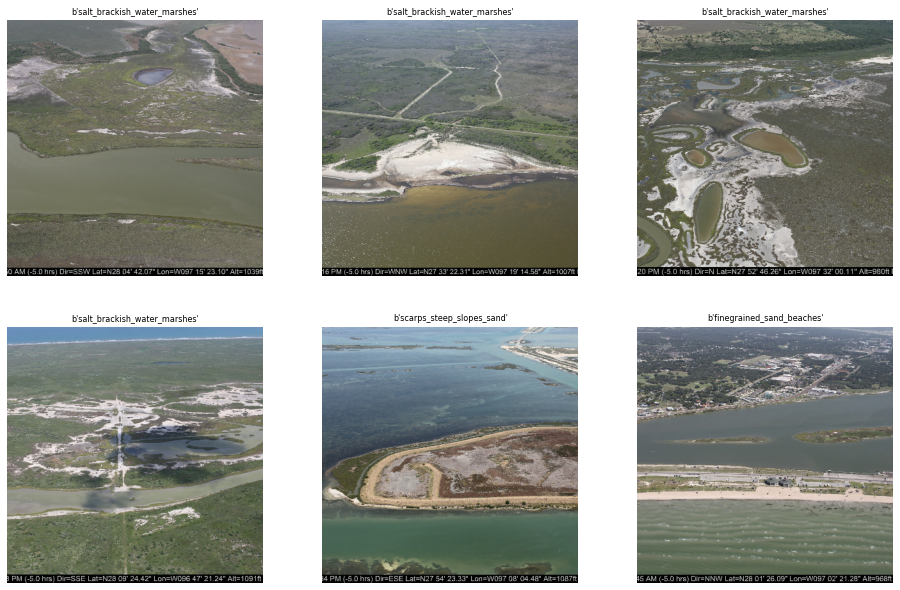

In [13]:
train_ds = get_training_dataset()

plt.figure(figsize=(16,16))
for imgs,lbls in train_ds.take(1):
  for count,im in enumerate(imgs):
     plt.subplot(int(BATCH_SIZE/2),int(BATCH_SIZE/2),count+1)
     plt.imshow(im)
     plt.title(CLASSES[lbls.numpy()[count]], fontsize=8)
     plt.axis('off')

Do the same for the validation set

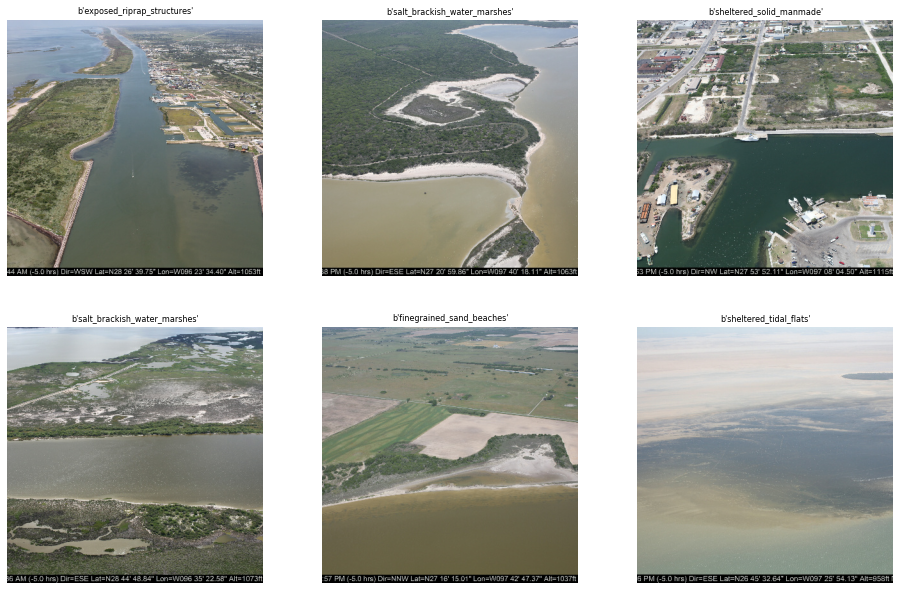

In [14]:
val_ds = get_validation_dataset()

plt.figure(figsize=(16,16))
for imgs,lbls in val_ds.take(1):
  for count,im in enumerate(imgs):
     plt.subplot(int(BATCH_SIZE/2),int(BATCH_SIZE/2),count+1)
     plt.imshow(im)
     plt.title(CLASSES[lbls.numpy()[count]], fontsize=8)
     plt.axis('off')

Get a set of training data and read it, associated classes, and indices of images of each class, into memory

If the cell crashes due to lack of memory, you will need to manually specify a lower number of batches

In [15]:
#-------------------------------------------------
training_filenames = sorted(tf.io.gfile.glob(data_path+os.sep+'*.tfrec'))
nb_images = ims_per_shard * len(training_filenames)
print(nb_images)

## num_batches=100

num_batches = int(((1-VALIDATION_SPLIT) * nb_images) / BATCH_SIZE)
print(num_batches)

X_train, ytrain, class_idx_to_train_idxs = get_train_stuff(num_batches)

3000
200


We create an instance of a `large` embedding model. I have provided two versions: 1) `get_embedding_model` (94,000) 2) `get_large_embedding_model` (390,000 parameters)

In [23]:
num_embed_dim = 16 

In [24]:
model1 = get_large_embedding_model(TARGET_SIZE, num_classes, num_embed_dim)

model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
     metrics=['accuracy'],
)

model1.summary()

Model: "embedding_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 199, 199, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 99, 99, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 49, 49, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 16)            

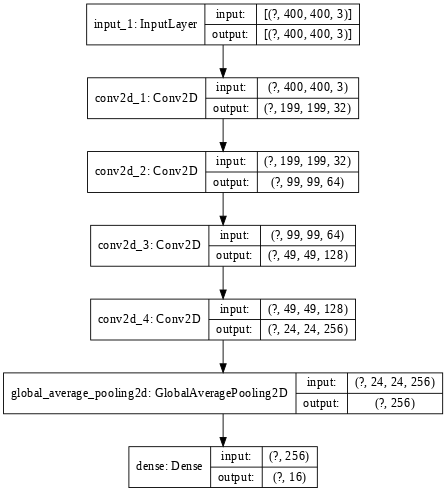

In [25]:
tf.keras.utils.plot_model(model1, show_shapes=True, dpi=64)

Like in previous weeks, define early stopping and a model checkpoint. This time, there is no concept of validation loss. Only training loss. We are providing the training set only to the model. It has no validation set to internal evaluate progress

So, early stopping is based on training loss (i.e. the ability of the model to embed imagery such that the distance between embeddings is large for different classes and small for the same class)

Model weight checkpoints are saved when the model training loss improves

In [26]:
earlystop = EarlyStopping(monitor="loss",
                              mode="min", patience=patience)

# set checkpoint file
model_checkpoint = ModelCheckpoint(filepath, monitor='loss',
                                verbose=0, save_best_only=True, mode='min',
                                save_weights_only = True)

callbacks = [model_checkpoint, earlystop]

If `do_train` is True, the model will train. This may take a while, wo we'll have a lecture to explain what the model is doing and how it will work

Epoch 1/100
200/200 [==============================] - 9s 44ms/step - loss: 2.4364 - accuracy: 0.1196
Epoch 2/100
200/200 [==============================] - 9s 43ms/step - loss: 2.3916 - accuracy: 0.1354
Epoch 3/100
200/200 [==============================] - 9s 44ms/step - loss: 2.3975 - accuracy: 0.1304
Epoch 4/100
200/200 [==============================] - 9s 44ms/step - loss: 2.3670 - accuracy: 0.1492
Epoch 5/100
200/200 [==============================] - 9s 44ms/step - loss: 2.3677 - accuracy: 0.1542
Epoch 6/100
200/200 [==============================] - 9s 43ms/step - loss: 2.3594 - accuracy: 0.1604
Epoch 7/100
200/200 [==============================] - 9s 43ms/step - loss: 2.3397 - accuracy: 0.1658
Epoch 8/100
200/200 [==============================] - 9s 44ms/step - loss: 2.3446 - accuracy: 0.1633
Epoch 9/100
200/200 [==============================] - 9s 43ms/step - loss: 2.3512 - accuracy: 0.1721
Epoch 10/100
200/200 [==============================] - 9s 44ms/step - loss: 2.329

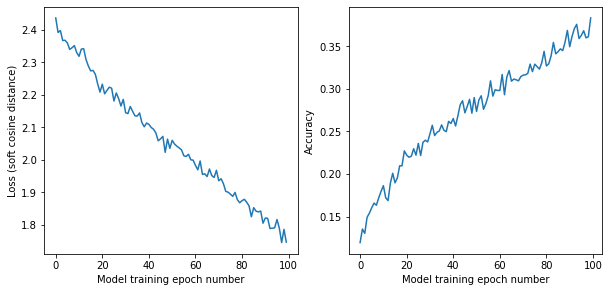

In [27]:
do_train = True

if do_train:
    history1 = model1.fit(AnchorPositivePairs(num_batchs=num_batches), epochs=max_epochs,
                          callbacks=callbacks)

    plt.figure(figsize = (10,10))
    plt.subplot(221)
    plt.plot(history1.history["loss"])
    plt.xlabel('Model training epoch number')
    plt.ylabel('Loss (soft cosine distance)')

    plt.subplot(222)
    plt.plot(history1.history["accuracy"])
    plt.xlabel('Model training epoch number')
    plt.ylabel('Accuracy')
    # plt.show()
    # plt.savefig(hist_fig, dpi=200, bbox_inches='tight')
    # plt.close('all')

else:
    model1.load_weights(filepath)


## Lecture

> How does this work?

Access slides [here](https://docs.google.com/presentation/d/1FODqB5y1I3HdTZ8IPVSqxNbN4UF7kHWs2xWovsbbSng/edit?usp=sharing)

(warning! still under development)



The above training didn't go on for long enough to convergence to an optimal solution. `max_epochs` should be larger. So below is the model training curve after more than 300 epochs - for reference

In [30]:
from IPython.display import Image

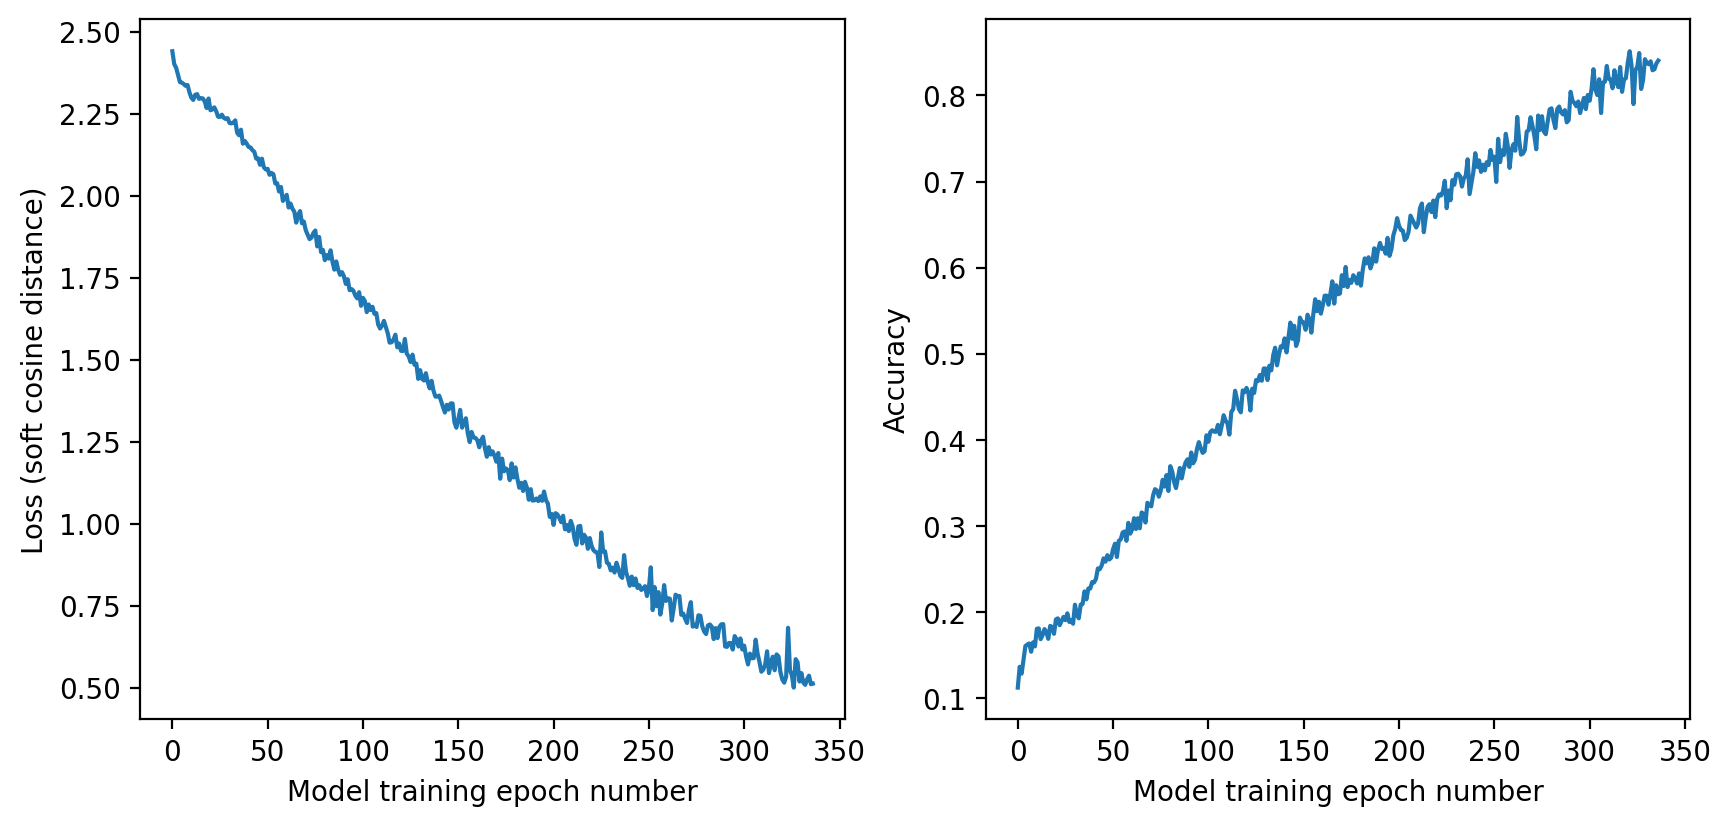

In [32]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_subset_12class_custom_model1.png", width=1000, height=500)

## Train an unsupervised classification model based on the embeddings

To consolidate memory, it is often a good idea to do this after model training or other extensive periods of GPU utilization

In [28]:
K.clear_session()

Let's load the weights from the full (~300 epoch) training session

In [29]:
filepath = os.getcwd()+os.sep+'results/weights_copy/tamucc_subset_12class_best_weights_model1.h5'

model1.load_weights(filepath)


Now we have a trained model, we can use it to extract embeddings from all training images, and build a kNN classifier 

We have a choice over how many of the embedding dimensions to use. When in doubt, use all of them, but all may not necessarily be required for the most parsimonious model

The global parameter `num_neighbors` could also be varied

In [33]:
# can be as low as 2
num_dim_use = num_embed_dim 

knn1 = fit_knn_to_embeddings(model1, X_train, ytrain, num_dim_use, n_neighbors)

# no longer require these variables, so delete them
del X_train, ytrain

Let's test the model. Start by getting the test set of images, class labels and class indices

In [34]:
X_test, ytest, class_idx_to_test_idxs = get_test_stuff(num_batches)

The variable `touse` is used to control the amount of data used for model evaluation. Below we use all the available data

We use the trained neural network model to extract the embeddings from the test imagery, then normalize those embeddings

Finally, pass the embeddings to the kNN model for prediction using its `.score()` option, which works like `model.evaluate` by providing the average accuracy over the entire provided test data

In [35]:
touse = len(X_test) #1000

embeddings_test = model1.predict(X_test[:touse])
embeddings_test = tf.nn.l2_normalize(embeddings_test, axis=-1)
del X_test

print('KNN score: %f' % knn1.score(embeddings_test[:,:num_dim_use], ytest[:touse]))

KNN score: 0.584167


Use the model to estimate classes of each validation image embedding, and print a confusion matrix to show the class observed-estimated correspondences

([<matplotlib.axis.YTick at 0x7efd4e4d9588>,
 [Text(0, 0.5, 'exposed_riprap_structures'),
  Text(0, 1.5, 'exposed_tidal_flats'),
  Text(0, 2.5, 'exposed_walls_other_structures'),
  Text(0, 3.5, 'finegrained_sand_beaches'),
  Text(0, 4.5, 'gravel_shell_beaches'),
  Text(0, 5.5, 'mixed_sand_gravel_shell_beaches'),
  Text(0, 6.5, 'salt_brackish_water_marshes'),
  Text(0, 7.5, 'scarps_steep_slopes_clay'),
  Text(0, 8.5, 'scarps_steep_slopes_sand'),
  Text(0, 9.5, 'sheltered_scarps'),
  Text(0, 10.5, 'sheltered_solid_manmade'),
  Text(0, 11.5, 'sheltered_tidal_flats')])

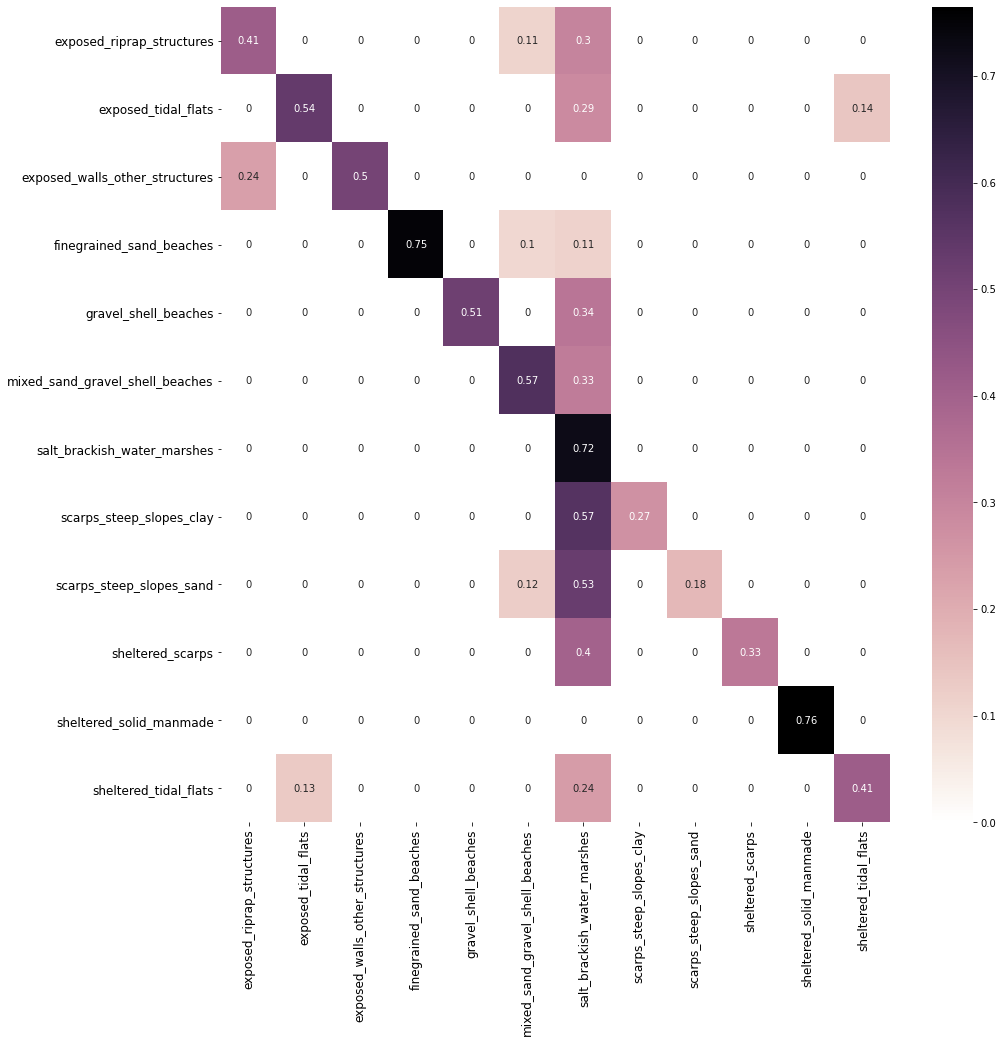

In [36]:
y_pred = knn1.predict(embeddings_test[:,:num_dim_use])

# p_confmat(ytest[:touse], y_pred, cm_filename, CLASSES, thres = 0.1)

labs = ytest[:touse]
preds = y_pred

cm = confusion_matrix(labs, preds)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

thres=0.1
cm[cm<thres] = 0

plt.figure(figsize=(15,15))
sns.heatmap(cm,
  annot=True,
  cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True))

tick_marks = np.arange(len(CLASSES))+.5
plt.xticks(tick_marks, [c.decode() for c in CLASSES], rotation=90,fontsize=12)
plt.yticks(tick_marks, [c.decode() for c in CLASSES],rotation=0, fontsize=12)


### Filtering based on prediction probability

Each kNN model has two prediction functions: 1) `.predict()`, like we saw earlier, that gives us the categorical class predictions, and 2) `predict_proba()` that gives us the prediction probabilities of each class

We can only consider the samples that the model feels confident about. These more 'sure' examples will have prediction probabilities at or near 1

Below I get the indices `ind` of only the test samples where the model prediction probability was 1

In [37]:
y_pred = knn1.predict_proba(embeddings_test[:,:num_dim_use])

y_prob = np.max(y_pred, axis=1)

y_pred = np.argmax(y_pred, axis=1)

ind = np.where(y_prob==1)[0]

print(len(ind))

370


View the confusion matrix based on these 'sure' samples

([<matplotlib.axis.YTick at 0x7efd4e2f3ef0>,
 [Text(0, 0.5, 'exposed_riprap_structures'),
  Text(0, 1.5, 'exposed_tidal_flats'),
  Text(0, 2.5, 'exposed_walls_other_structures'),
  Text(0, 3.5, 'finegrained_sand_beaches'),
  Text(0, 4.5, 'gravel_shell_beaches'),
  Text(0, 5.5, 'mixed_sand_gravel_shell_beaches'),
  Text(0, 6.5, 'salt_brackish_water_marshes'),
  Text(0, 7.5, 'scarps_steep_slopes_clay'),
  Text(0, 8.5, 'scarps_steep_slopes_sand'),
  Text(0, 9.5, 'sheltered_scarps'),
  Text(0, 10.5, 'sheltered_solid_manmade'),
  Text(0, 11.5, 'sheltered_tidal_flats')])

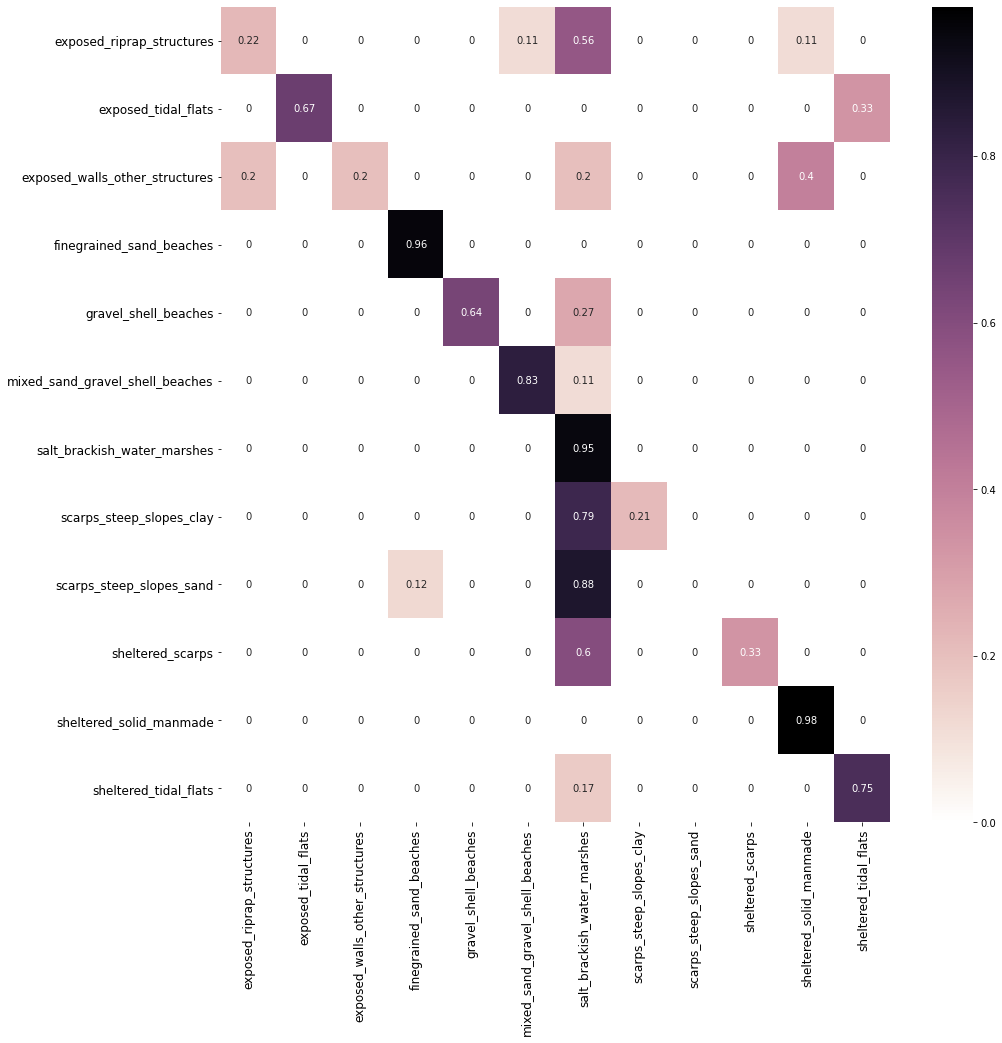

In [38]:
# p_confmat(ytest[:touse][ind], y_pred[ind], cm_filename.replace('val', 'val_v2'), CLASSES, thres = 0.1)

labs = ytest[:touse][ind]
preds = y_pred[ind]

cm = confusion_matrix(labs, preds)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

thres=0.1
cm[cm<thres] = 0

plt.figure(figsize=(15,15))
sns.heatmap(cm,
  annot=True,
  cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True))

tick_marks = np.arange(len(CLASSES))+.5
plt.xticks(tick_marks, [c.decode() for c in CLASSES], rotation=90,fontsize=12)
plt.yticks(tick_marks, [c.decode() for c in CLASSES],rotation=0, fontsize=12)


How does this compare to the model trained over more epochs?

This is the matrix on the entire validation set

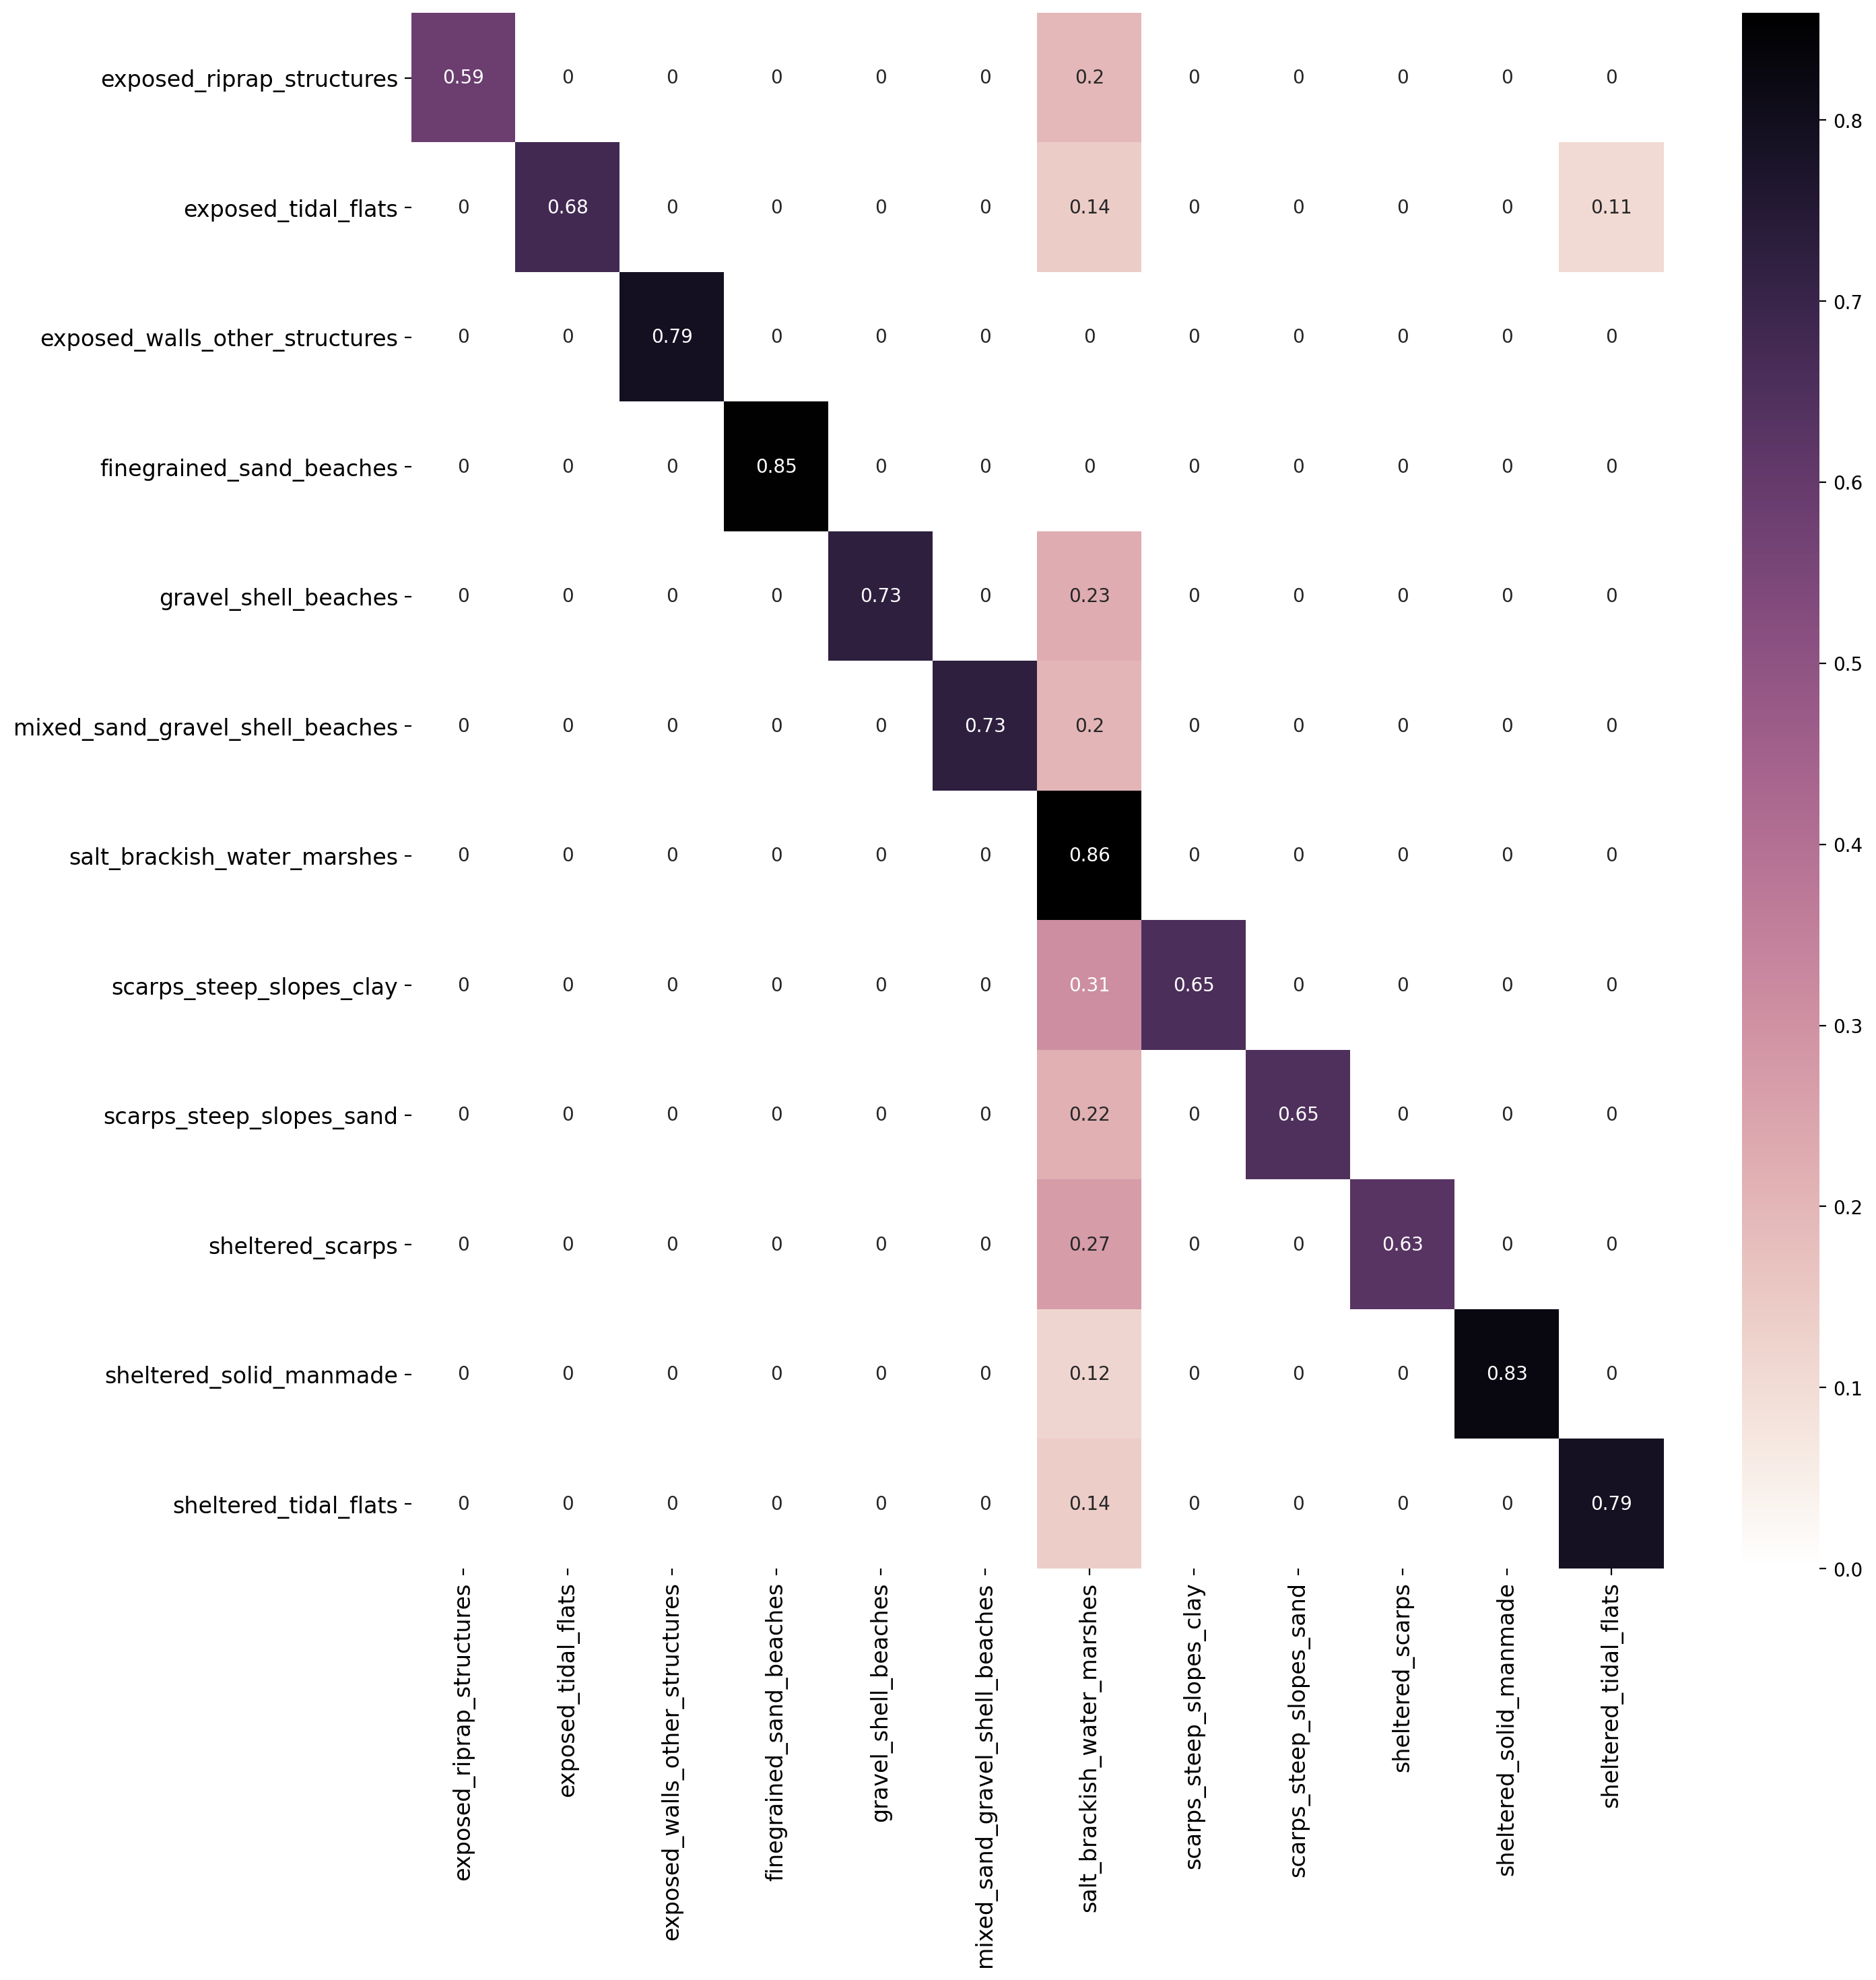

In [39]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_sample_12class_model1_cm_val.png", width=500, height=500)

This is the matrix with only the 'sure' predictions

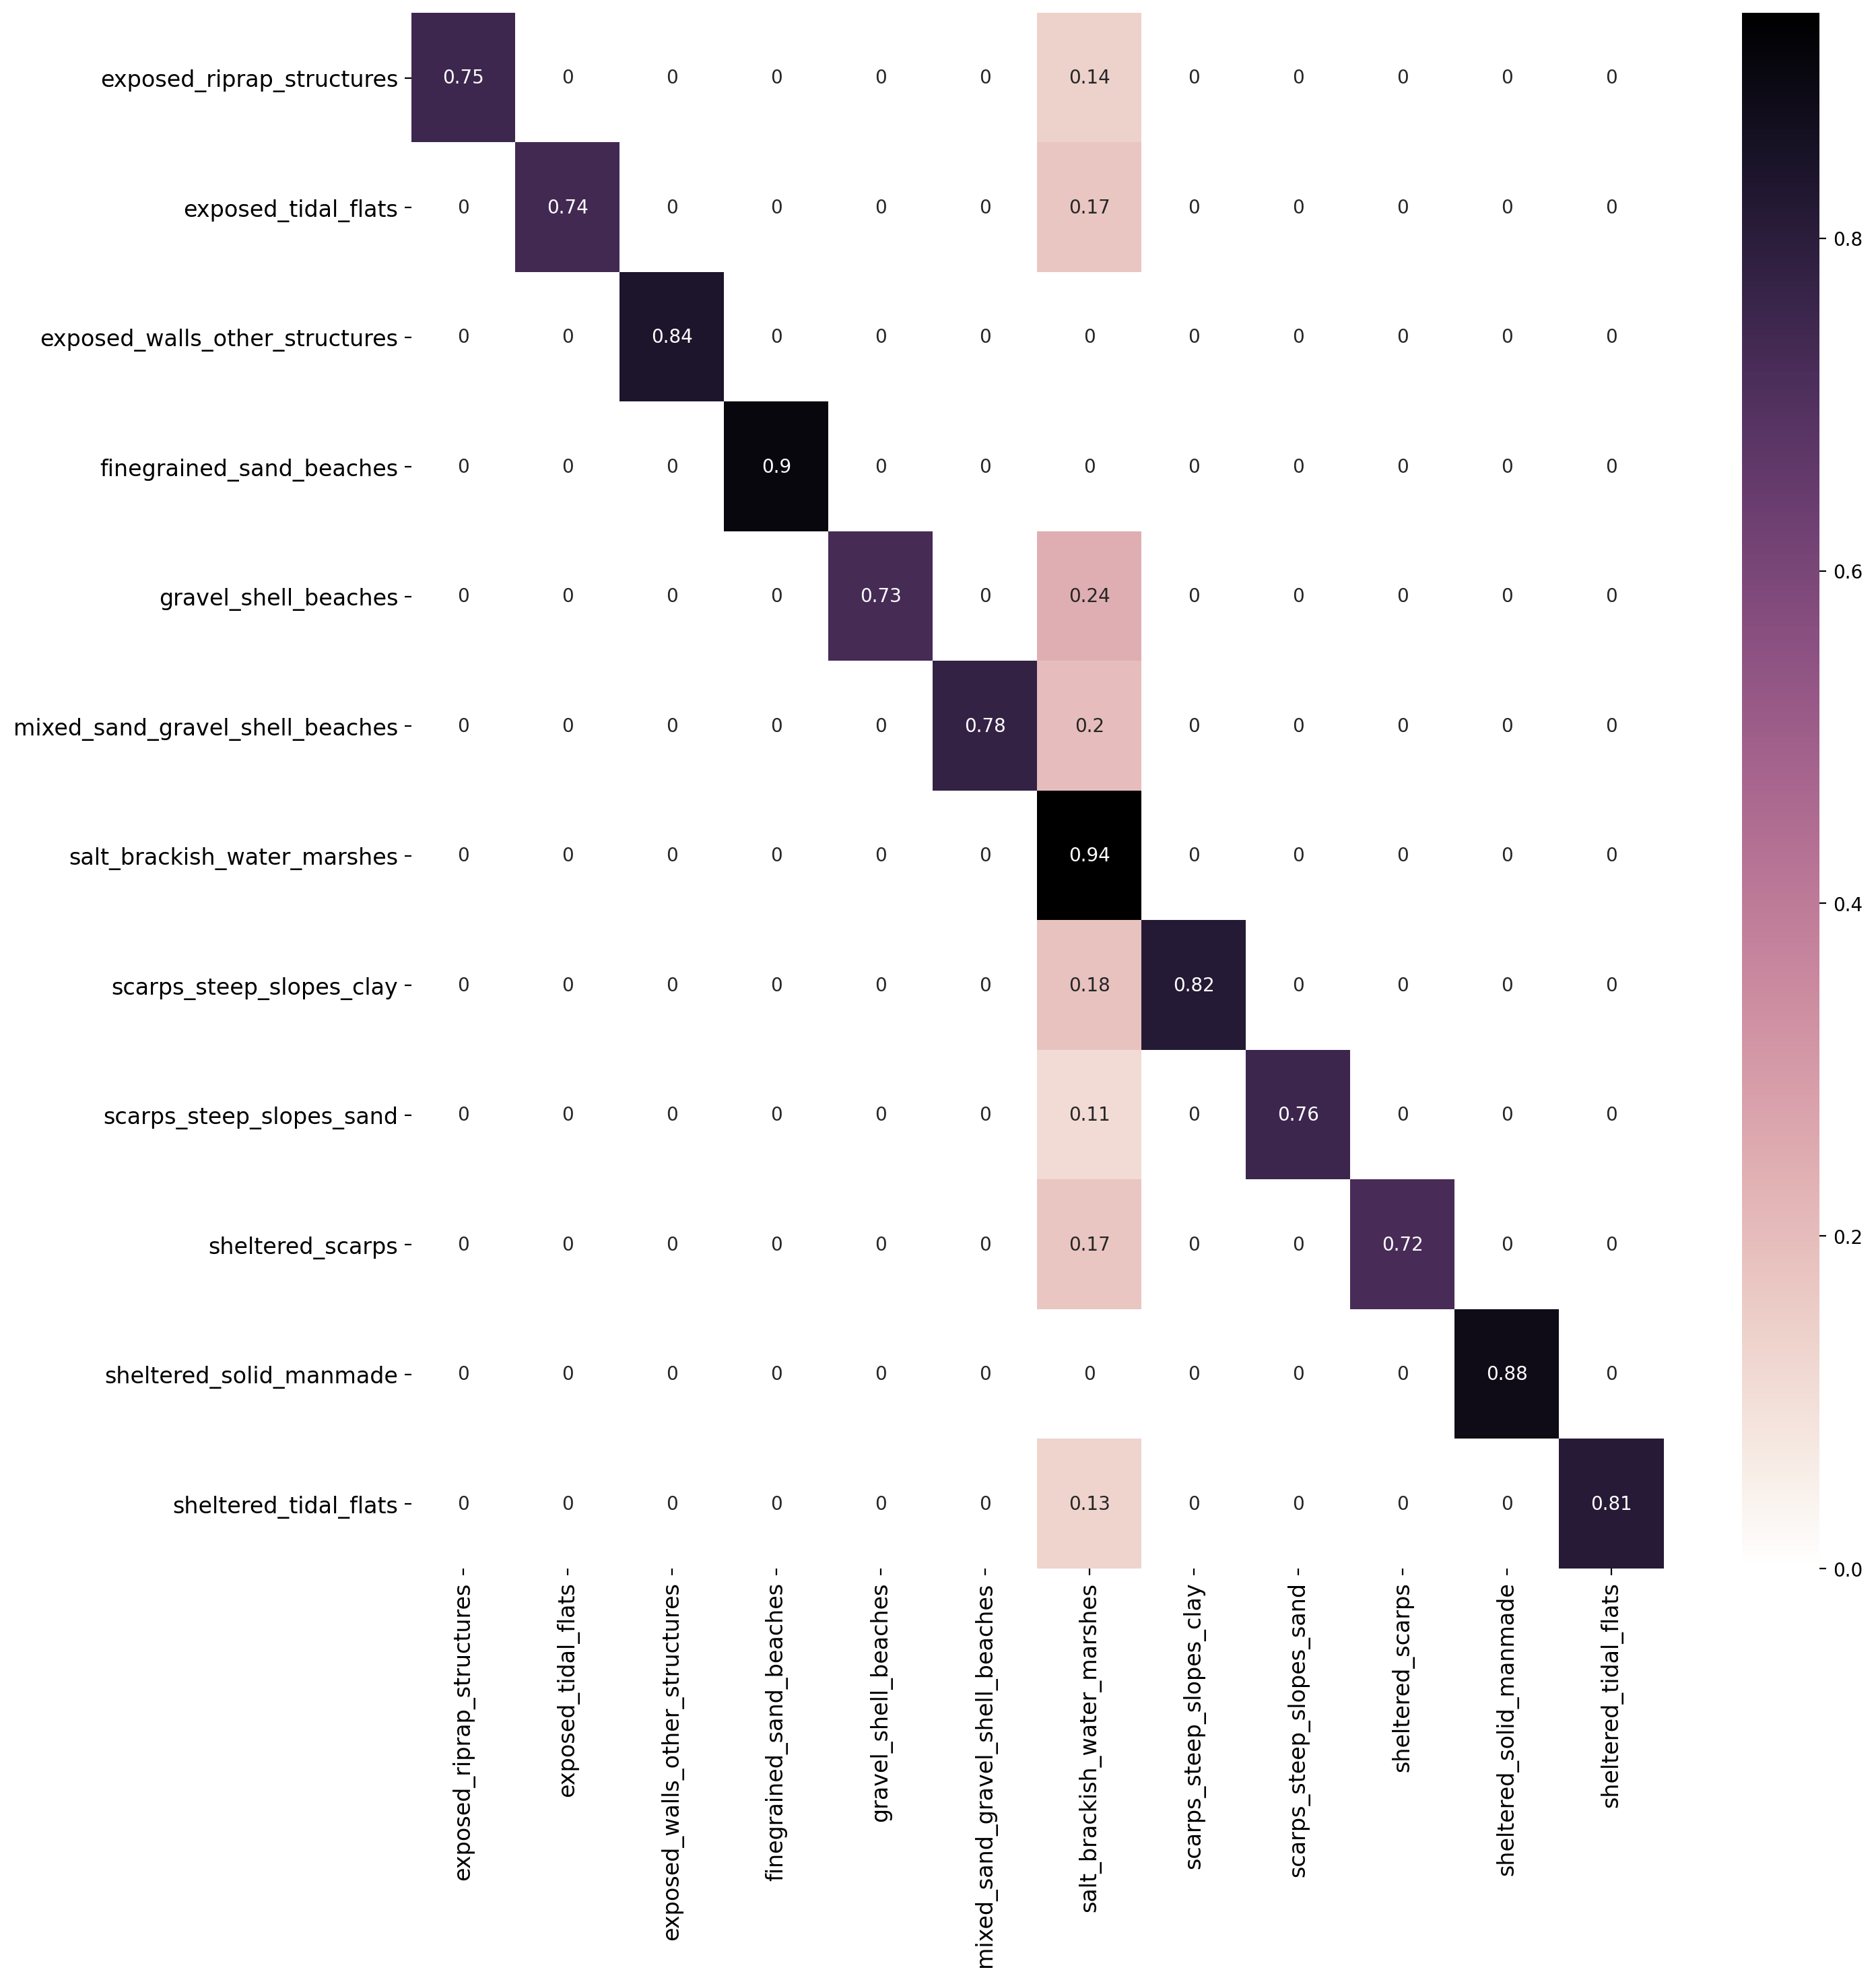

In [40]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_sample_12class_model1_cm_val_v2.png", width=500, height=500)

### Model fine-tuning

Can we do better? At this point, it would be common to try to ***fine-tune*** the model. This usually involves training for longer at a lower learning rate, in the hope that it will find further optimal solutions in the loss landscape

We could also freeze model layers at this point, so lower layers can no longer learn but higher layers are still free to. However, in the spirit of experimentation (i.e. only varying one variable at a time), we'll leave the model as is, increase the `patience` to 20, lower the learning rate to `5e-5` (i.e. half a magnitude step down in learning rate), and train again with a starting point of the best weights from the previous model training 


In [41]:
del ytest, class_idx_to_test_idxs

X_train, ytrain, class_idx_to_train_idxs = get_train_stuff(num_batches)

We'll generate a new set of model outputs, and we need new variables for the old and new model weights

In [42]:
json_file = os.getcwd()+os.sep+'data/tamucc/subset_12class/tamucc_subset_12classes.json'

data_path= os.getcwd()+os.sep+"data/tamucc/subset_12class/400"
test_samples_fig = os.getcwd()+os.sep+'results/tamucc_sample_12class_model2_est36samples.png'

cm_filename = os.getcwd()+os.sep+'results/tamucc_sample_12class_model2_cm_val.png'

sample_data_path= os.getcwd()+os.sep+"data/tamucc/subset_12class/sample"

filepath = os.getcwd()+os.sep+'results/tamucc_subset_12class_best_weights_model2.h5'

hist_fig = os.getcwd()+os.sep+'results/tamucc_subset_12class_custom_model2.png'

cm_fig = os.getcwd()+os.sep+'results/tamucc_subset_12class_cm_test_model2.png'

initial_filepath = os.getcwd()+os.sep+'results/weights_copy/tamucc_subset_12class_best_weights_model1.h5'


Make a new model instance, set the new learning rate and patience, compile, and create callbacks for early stopping and model checkpoint, like before

In [43]:
model2 = get_large_embedding_model(TARGET_SIZE, num_classes, num_embed_dim)

# use a smaller learning rate, because we are fine-tuning
lr = 5e-5

patience = 20

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
     metrics=['accuracy'],
)
earlystop = EarlyStopping(monitor="loss",
                              mode="min", patience=patience)

# set checkpoint file
model_checkpoint = ModelCheckpoint(filepath, monitor='loss',
                                verbose=0, save_best_only=True, mode='min',
                                save_weights_only = True)

callbacks = [model_checkpoint, earlystop]

Initialize the model with the weights of the previous model. We want to train on top of these weights. This is another form of transfer learning

In [44]:
# load with previous weights
model2.load_weights(initial_filepath)

Training in class would take too long, so we will set `do_train` to False, load the previously trained weights and use it for classification purposes (to save time)

In your own time, go ahead and train the model

In [45]:
do_train = False #True

if do_train:
    history1 = model2.fit(AnchorPositivePairs(num_batchs=num_batches), epochs=max_epochs,
                          callbacks=callbacks)

    plt.figure(figsize = (10,10))
    plt.subplot(221)
    plt.plot(history1.history["loss"])
    plt.xlabel('Model training epoch number')
    plt.ylabel('Loss (soft cosine distance)')

    plt.subplot(222)
    plt.plot(history1.history["accuracy"])
    plt.xlabel('Model training epoch number')
    plt.ylabel('Accuracy')
    # plt.show()
    # plt.savefig(hist_fig, dpi=200, bbox_inches='tight')
    # plt.close('all')

else:
    model2.load_weights(filepath)

### Ensemble classification model

Okay, so now we have a fine-tuned model and its losses are lower and accuracies slightly higher - great!

Next, we'll create our kNN model as before. This time, however, we'll make 2 alternative models that use, respectively, 5 and 7 nearest neighbours instead of 3

We will take all 3 models and make ensemble predictions. Then we'll see how well those ensembles classify the imagery

In [46]:
num_dim_use = num_embed_dim #2

knn3 = fit_knn_to_embeddings(model2, X_train, ytrain, num_dim_use, n_neighbors)

knn5 = fit_knn_to_embeddings(model2, X_train, ytrain, num_dim_use, 5)

knn7 = fit_knn_to_embeddings(model2, X_train, ytrain, num_dim_use, 7)

del X_train, ytrain

Load in our test data one more time, and use the trained fine-tuned model to estimate embeddings

In [47]:
X_test, ytest, class_idx_to_test_idxs = get_test_stuff(num_batches)

touse = len(X_test) 

# touse = 300

embeddings_test = model2.predict(X_test[:touse])
embeddings_test = tf.nn.l2_normalize(embeddings_test, axis=-1)
del X_test

Each kNN model has two prediction functions: 1) `.predict()`, like we saw earlier, that gives us the categorical class predictions, and 2) `predict_proba()` that gives us the prediction probabilities of each class

Below we use each model to get both the classes and the prediction probabilities

We will use the probabilities, like we did before, to filter out the 'uncertain' classifications

In [48]:
y_pred1 = knn3.predict(embeddings_test[:,:num_dim_use])
y_pred2 = knn5.predict(embeddings_test[:,:num_dim_use])
y_pred3 = knn7.predict(embeddings_test[:,:num_dim_use])

y_prob1 = knn3.predict_proba(embeddings_test[:,:num_dim_use])
y_prob2 = knn5.predict_proba(embeddings_test[:,:num_dim_use])
y_prob3 = knn7.predict_proba(embeddings_test[:,:num_dim_use])

How good are they on average?

In [49]:
score1 = knn3.score(embeddings_test[:,:num_dim_use], ytest[:touse])
score2 = knn5.score(embeddings_test[:,:num_dim_use], ytest[:touse])
score3 = knn7.score(embeddings_test[:,:num_dim_use], ytest[:touse])

print('3-NN score: %f' % score1)
print('5-NN score: %f' % score2)
print('7-NN score: %f' % score3)

3-NN score: 0.770833
5-NN score: 0.774167
7-NN score: 0.775833


The ensembling strategy adopted below is one of concatenating the class estimate vectors of the three models (`mask`). This is an Nx3 matrix

Then find any row where any model's predictions are greater than a 0.9 -- this is arbitrary, so modify as necessary


In [50]:
mask = np.c_[y_pred1, y_pred2, y_pred3]

use = np.any(mask>.9, axis=1) #only predictions where all probabilities are > 0.9
mask = mask[use,:]

# weighted average - you might decide to use this based on each model's average scores
# y_en = np.round(np.average(mask, axis=1, weights=[.1, .1, .5]))

y_en = np.median(mask, axis=1)

Finally, make a confusion matrix

We'll see that the ensemble model isn't any better in this case - in fact, it is slightly worse!

The ensembling approach may work better for other datasets, or perhaps there is a better way to ensemble these models?

([<matplotlib.axis.YTick at 0x7efd4c49aba8>,
 [Text(0, 0.5, 'exposed_riprap_structures'),
  Text(0, 1.5, 'exposed_tidal_flats'),
  Text(0, 2.5, 'exposed_walls_other_structures'),
  Text(0, 3.5, 'finegrained_sand_beaches'),
  Text(0, 4.5, 'gravel_shell_beaches'),
  Text(0, 5.5, 'mixed_sand_gravel_shell_beaches'),
  Text(0, 6.5, 'salt_brackish_water_marshes'),
  Text(0, 7.5, 'scarps_steep_slopes_clay'),
  Text(0, 8.5, 'scarps_steep_slopes_sand'),
  Text(0, 9.5, 'sheltered_scarps'),
  Text(0, 10.5, 'sheltered_solid_manmade'),
  Text(0, 11.5, 'sheltered_tidal_flats')])

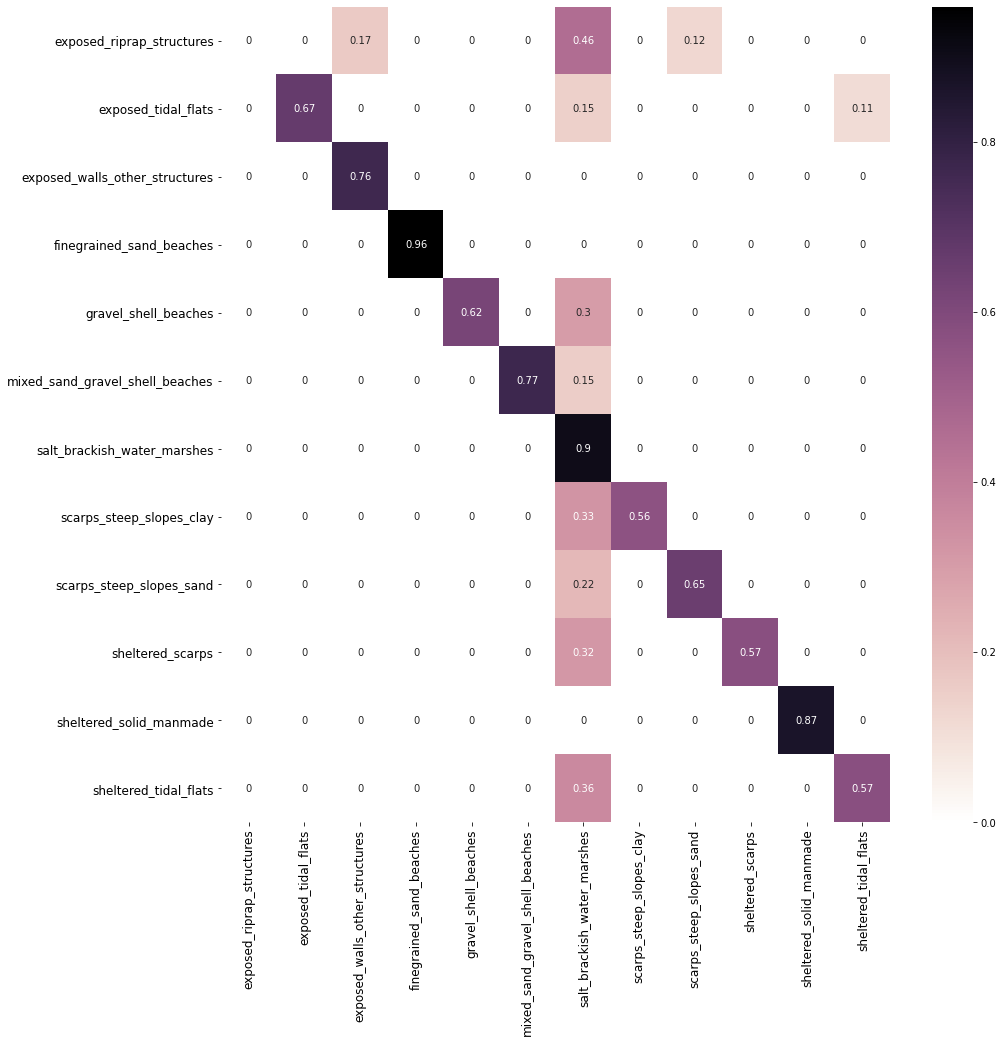

In [51]:
labs = ytest[:touse][use]
preds = y_en

cm = confusion_matrix(labs, preds)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

thres=0.1
cm[cm<thres] = 0

plt.figure(figsize=(15,15))
sns.heatmap(cm,
  annot=True,
  cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True))

tick_marks = np.arange(len(CLASSES))+.5
plt.xticks(tick_marks, [c.decode() for c in CLASSES], rotation=90,fontsize=12)
plt.yticks(tick_marks, [c.decode() for c in CLASSES],rotation=0, fontsize=12)

### NWPU dataset

How does this semi-supervised model work on the NWPU data?

Very well!

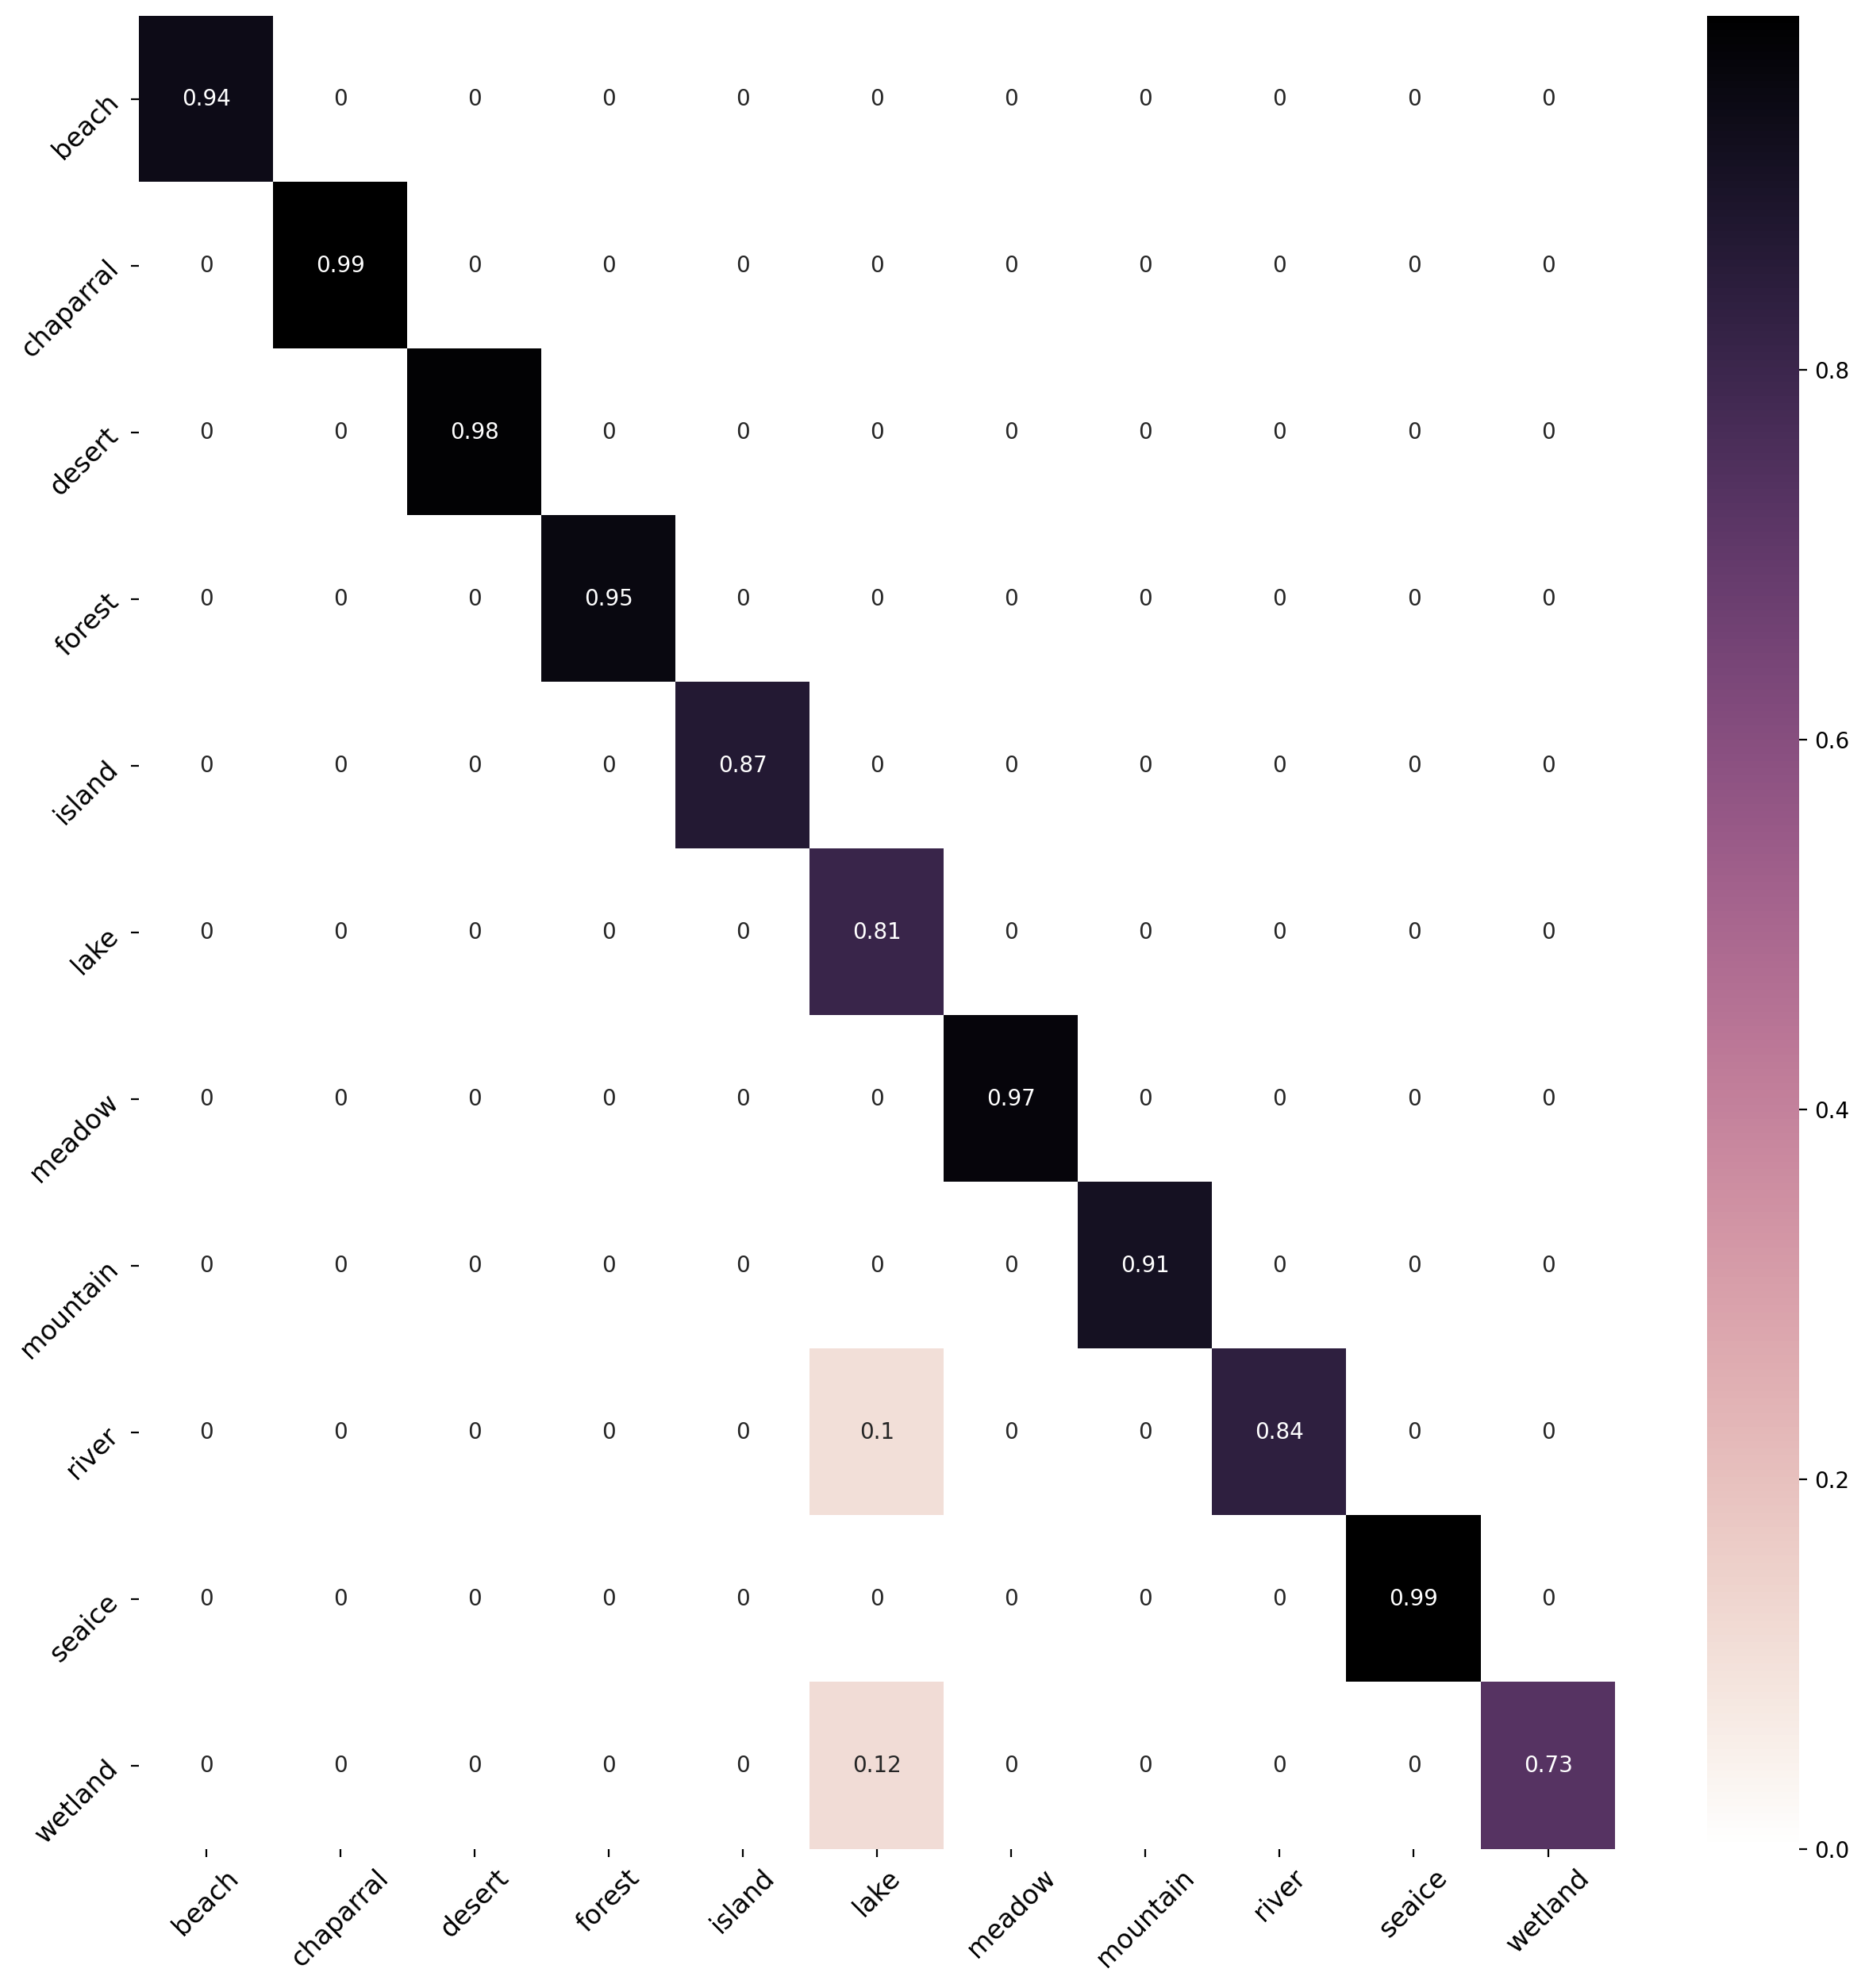

In [52]:
Image(filename = os.getcwd()+os.sep + "results/nwpu_sample_11class_model1_cm_val.png", width=500, height=500)

You can reproduce (and tweak) this workflow by running the provided script:

In [49]:
#!python nwpu_ssimrecog_part1.py


### Live discussion points
* How does this work?
* What are the biggest levers on training? (learning rate, augmentation, model architecture, amount of data, number of nearest neighbours, etc)
* Why is accuracy better for NWPU data compared to TAMUCC data?
* How to apply to your data?
* Is it possible to use transfer learning, in this case?